# Chronos Vignette

This vignette walks through a simple exercise in training Chronos on a subset of DepMap public 20Q4 and the Sanger Institute's Project Score data. 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import chronos
import os
from matplotlib import pyplot as plt
import seaborn as sns
from taigapy import default_tc as tc

Some tweaks that will make plots more legible

In [3]:
from matplotlib import rcParams
rcParams['axes.titlesize'] = 14
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['savefig.dpi'] = 200
rcParams['savefig.transparent'] = False
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = '11'
rcParams['figure.dpi'] = 200
rcParams["savefig.facecolor"] = (1, 1, 1.0, 0.2)

rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 7

## Setting up the Data

Chronos always requires at least three dataframes: 
* a matrix of readcounts with sequenced entities as the index, individual sgRNAs as the columns, and values indicating how many reads were found for that sgRNA. A sequenced entity any vector of sgRNA readcounts read out during the experiment. It could be a sequencing run of pDNA, or of a biological replicate at some time point during the experiment.
* A sequence map mapping sequenced entities to either pDNA or a cell line and giving the days since infection and pDNA batch. 
* A guide map mapping sgRNAs to genes. Each sgRNA included must map to one and only one gene.

Below, we'll load a small subset of the DepMap Avana data. The files have been reformatted from the release to the format Chronos expects

In [4]:
sequence_map = pd.read_csv("Data/SampleData/AvanaSequenceMap.csv")
guide_map = pd.read_csv("Data/SampleData/AvanaGuideMap.csv")
readcounts = chronos.read_hdf5("Data/SampleData/AvanaReadcounts.hdf5")

Sequence maps must have the columns

* sequence_id (str), which must match a row in readcounts
* cell_line_name (str). Must be "pDNA" for pDNA, and each pDNA batch must have at least one pDNA measurement.
* pDNA batch (any simple hashable type, preferably int or str). pDNA measurements sharing the same batch will be grouped and averaged, then used as the reference for all biological replicate sequencings assigned that same batch. If you don't have multiple pDNA batches (by far the most common experimental condition), just fill this column with 0 or some other constant value.
* days: days post infection. This value will be ignored for pDNA.

Other columns will be ignored.

In [5]:
sequence_map[:5]

,sequence_ID,ScreenID,days,pDNA_batch,Replicate,ScreenType,cell_line_name,ModelConditionID,Library,PassesQC
0,HEL-311Cas9_RepA_p4_Avana-3,SC-000004.AV01,21,Avana-3,A,2DS,ACH-000004,MC-000004-pA3k,Avana,True
1,HEL-311Cas9_RepB_p4_Avana-3,SC-000004.AV01,21,Avana-3,B,2DS,ACH-000004,MC-000004-pA3k,Avana,True
2,KU812-311cas9-RepA-p6_Avana-3,SC-000074.AV01,21,Avana-3,A,2DS,ACH-000074,MC-000074-OKtM,Avana,True
3,KU812-311cas9-RepB-p6_Avana-3,SC-000074.AV01,21,Avana-3,B,2DS,ACH-000074,MC-000074-OKtM,Avana,True
4,T47D-311Cas9-RepA-p6_Avana-4,SC-000147.AV01,21,Avana-4,A,2DS,ACH-000147,MC-000147-Uovr,Avana,True


Guide maps must have the columns 

* sgrna (str): must match a column in readcounts. An sgrna can only appear once in this data frame.
* gene (str): the gene the sgrna maps to.

Other columns will be ignored.

In [6]:
guide_map[:4]

,sgrna,GenomeAlignment,gene,nAlignments,DropReason,UsedByChronos
0,AAAAATGCGCAAATTCAGCG,chr3_138742712_-,PIK3CB (5291),1.0,NaN,True
1,AAAACACATCAGTATAACAT,chr3_49368469_+,RHOA (387),1.0,NaN,True
2,AAAACTACAGAAGCCTCCCG,chr10_34450424_-,PARD3 (56288),1.0,NaN,True
3,AAAAGGCCTGACATATCTGA,chr15_66444677_+,MAP2K1 (5604),2.0,NaN,True


Finally, here's what readcounts should look like. They can include NaNs. Note the axes.

In [7]:
readcounts.iloc[:4, :3]

,AAAAATGCGCAAATTCAGCG,AAAACACATCAGTATAACAT,AAAACTACAGAAGCCTCCCG
HEL-311Cas9_RepA_p4_Avana-3,101.0,224.0,636.0
HEL-311Cas9_RepB_p4_Avana-3,147.0,400.0,350.0
KU812-311cas9-RepA-p6_Avana-3,124.0,191.0,364.0
KU812-311cas9-RepB-p6_Avana-3,129.0,536.0,1280.0


To QC the data, we'll want control groups. We'll use predefined sets of common and nonessential genes, and use these to define control sets of sgRNAs.

In [8]:
common_essentials = pd.read_csv("Data/SampleData/AchillesCommonEssentialControls.csv")["Gene"]
nonessentials = pd.read_csv("Data/SampleData/AchillesNonessentialControls.csv")["Gene"]

In [9]:
positive_controls = guide_map.sgrna[guide_map.gene.isin(common_essentials)]
negative_controls = guide_map.sgrna[guide_map.gene.isin(nonessentials)]

### NaNing clonal outgrowths

In Achilles, we've observed rare instances where a single guide in a single biological replicate will produce an unexpectedly large number of readcounts, while other guides targeting the same gene or other replicates of the same cell line do not show many readcounts. We suspect this is the result of a single clone gaining some fitness advantage. Although it _could_ be related to a change induced by the guide, in general it's probably misleading. Therefore Chronos has an option to identify and remove these events.

In [10]:
chronos.nan_outgrowths(readcounts=readcounts, guide_gene_map=guide_map,
                                   sequence_map=sequence_map)

calculating LFC
finding maximum LFC calls
filtering
finding second highest LFC calls
finding sequences and guides with outgrowth


/Users/dempster/packages/chronos_public/chronos/model.py:421: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  max_lfc = lfc.groupby(ggtemp, axis=1).max()
/Users/dempster/packages/chronos_public/chronos/model.py:436: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  max_row_2nd_column = lfc_filtered.T.groupby(ggtemp, axis=0).agg(second_highest).T


NAing 296 readcounts (0.00090 of total)


### QCing the data

You can generate a report with basic QC metrics about your data. You don't have to have control guides to do this, but the report is most useful if you do. If you don't have the `reportlab` python package installed, this section will error and should be skipped. This command will write a pdf report named "Initial QC.pdf" in the `./Data/reports` directory.

In [11]:
reportdir = "./Data/reports"
# permanently deletes the directory - careful if you edit this line!
! rm -rf "./Data/reports"
! mkdir "./Data/reports"

In [12]:
from chronos import reports
metrics = reports.qc_initial_data("Initial QC", readcounts, sequence_map,guide_map, 
        negative_controls, positive_controls,
                  directory=reportdir
       )

/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

calculating replicate correlation
generating control separation metrics
Plotting log fold-change distribution


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


plotting control separation metrics


/Users/dempster/packages/chronos_public/chronos/evaluations.py:317: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/reports.py:210: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/evaluations.py:317: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/reports.py:210: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/evaluations.py:317: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/reports.py:210: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/evaluations.py:317: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/

Look in the Data/reports directory to see the QC report, "Initial QC.pdf".

## Train Chronos

### Creating the model

Now we initialize the model. Note the form of the data: each of the three parameters is actually a dictionary. If we were training the model with data from multiple libraries simultaneously, each library's data would have its own entries in the dict. 

The `negative_control_sgrnas` is an optional parameter, but including it will allow 1. better removal of library size effects from readcounts, and 2. estimation of the negative binomial quadratic overdispersion parameter per screen, which is otherwise a fixed hyperparameter. If provided, these should be cutting sgRNAs that are strongly expected to have no viability impact.

`log_dir` is an optional argument containing a directory for tensorflow to write summaries to. We include it here so that tensorboard can load the model.

In [13]:
logdir = "./Data/logs"
# permanently deletes the directory - careful if you edit this line!
! rm -rf "./Data/logs"
! mkdir "./Data/logs"

In [14]:
model = chronos.Chronos(
    sequence_map={"avana": sequence_map},
    guide_gene_map={"avana": guide_map},
    readcounts={"avana": readcounts},
    negative_control_sgrnas={"avana": negative_controls},
    log_dir=logdir
)

normalizing readcounts


Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 3474 unique guides and 883 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA) and 44 unique cell lines in avana
found 92 unique replicates and 44 unique cell lines overall

finding replicate-cell line mappings indices

finding replicate-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
Between 0 (batch=Index(['avana_Avana-2', 'avana_Avana-3', 'avana_Avana-4'], dtype='object')) and 0 (batch=Index(['avana_Avana-2', 'avana_Avana-3', 'avana_Avana-4'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
Creating excess variance tensors
	Created excess variance tensor for avana with shape [92, 1]
init

/Users/dempster/packages/chronos_public/chronos/model.py:1222: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\
2024-02-01 13:32:33.324898: W tensorflow/c/c_api.cc:304] Operation '{name:'excess_variance/avana/Assign' id:6 op device:{requested: '', assigned: ''} def:{{{node excess_variance/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance/avana, excess_variance/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



building t0 reads regularization/cost

building NB2 cost
building other regularizations

Creating optimizer
	creating log at ./Data/logs
initializing rest of graph
estimating initial screen efficacy and gene effect
	 avana


2024-02-01 13:32:33.748156: W tensorflow/c/c_api.cc:304] Operation '{name:'GE/library_effect/avana/Assign' id:149 op device:{requested: '', assigned: ''} def:{{{node GE/library_effect/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE/library_effect/avana, GE/library_effect/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/dempster/packages/chronos_public/chronos/model.py:1828: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map.set_index("sgrna").gene, axis=1)\


	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	avana _gene_effect
	avana _selected_efficacies
	avana_predicted_readcounts_unscaled
	avana _predicted_readcounts
	avana _normalized_readcounts
	avana _cost_presum
sess run
	avana _cost
	avana _full_costs
ready to train


If you have tensorboard, the cell below will show Chronos' node structure. `GE` means gene effect (relative change in growth rate), `FC` means predicted fold change, `t0` is the inferred relative guide abundance at t0, and `out_norm` is the predicted readcounts. 

In [15]:
%reload_ext tensorboard
!kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
%tensorboard --logdir ./data/logs

Now, optimizing the model:

### Train

Below, we train  the model for 301 epochs. This should take a minute or so with periodic updates provided

In [16]:
model.train(301, report_freq=50, burn_in_period=50, ge_only=0)

NB2 cost 0.3341174848630964
Full cost 0.4174937610619505
relative_growth_rate
	avana max 1.030, min 0.96592
mean guide efficacy 0.9992159002078269
t0_offset SD: [('avana', 7.072693015439669e-05)]

gene mean -0.21122822786625617
SD of gene means 0.29797706729162987
Mean of gene SDs 0.2506958081781616



51 epochs trained, time taken 0:00:02, projected remaining 0:00:08
NB2 cost 0.2240442003655348
Full cost 0.26235568223219063
relative_growth_rate
	avana max 1.403, min 0.59737
mean guide efficacy 0.9382300184387284
t0_offset SD: [('avana', 0.1435077953730121)]

gene mean -0.03143626934599289
SD of gene means 0.4271790867104013
Mean of gene SDs 0.21274978305810177



101 epochs trained, time taken 0:00:03, projected remaining 0:00:06
NB2 cost 0.21367579903827447
Full cost 0.23866571329059907
relative_growth_rate
	avana max 1.617, min 0.46159
mean guide efficacy 0.8825439434659323
t0_offset SD: [('avana', 0.13652048053077967)]

gene mean -0.0005063264142165703
SD of gene means 0.4327997433

## After Training

### Saving and Restoring

Chronos' `save` method dumps all the inputs, outputs, and model parameters to the specified directory. These files are written such that they can be read in individually and analyzed, but also used to restore the model by passing the directory path to the function `load_saved_model`.

In [17]:
savedir = "Data/Achilles_run_compare"

In [18]:
if not os.path.isdir(savedir):
    os.mkdir(savedir)

In [19]:
model.save(savedir, overwrite=True)

In [20]:
print("Saved files:\n\n" + '\n'.join(['\t' + s for s in os.listdir(savedir)
                if s.endswith("csv")
                or s.endswith("hdf5")
                or s.endswith("json")
                ]))

Saved files:

	library_effect.csv
	cell_line_growth_rate.csv
	avana_predicted_readcounts.hdf5
	parameters.json
	guide_efficacy.csv
	avana_sequence_map.csv
	t0_offset.csv
	avana_predicted_lfc.hdf5
	avana_guide_gene_map.csv
	gene_effect_corrected.hdf5
	avana_negative_control_sgrnas.csv
	screen_delay.csv
	screen_excess_variance.csv
	cell_line_efficacy.csv
	gene_effect.hdf5
	avana_readcounts.hdf5


The .hdf5 files are binaries written with chronos' `write_hdf5` function, which is an efficient method for writing large matrices. They can be read with chronos' `read_hdf5` function.

Restoring the model can be done with a single function call:

In [21]:
model_restored = chronos.load_saved_model(savedir)



Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 3474 unique guides and 883 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA) and 44 unique cell lines in avana
found 92 unique replicates and 44 unique cell lines overall

finding replicate-cell line mappings indices

finding replicate-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
Between 0 (batch=Index(['avana_avana_Avana-2', 'avana_avana_Avana-3', 'avana_avana_Avana-4'], dtype='object')) and 0 (batch=Index(['avana_avana_Avana-2', 'avana_avana_Avana-3', 'avana_avana_Avana-4'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
Creating excess variance tensors
	Created excess variance tensor for avana with shape

/Users/dempster/packages/chronos_public/chronos/model.py:1222: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\
2024-02-01 13:32:46.450156: W tensorflow/c/c_api.cc:304] Operation '{name:'excess_variance_1/avana/Assign' id:3131 op device:{requested: '', assigned: ''} def:{{{node excess_variance_1/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_1/avana, excess_variance_1/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


built core gene effect: 44 cell lines by 883 genes


Connecting graph nodes in model

building effective days
built effective days, shapes {'avana': [92, 883]}

building gene effect growth graph nodes
built gene effect growth graph nodes, shapes {'avana': [44, 883]}

building combined efficacy
built combined efficacy, shape {'avana': [44, 3474]}
built expanded combined efficacy, shapes {'avana': [92, 3474]}

building growth estimates of edited cells and overall estimates of fold change in guide abundance
built growth and change

building unnormalized estimates of final abundance
built unnormalized abundance

building normalized estimates of final abundance
built normalized abundance
initializing precost variables


Building all costs

assembling guide efficacy regularization
building smoothed regularization

building t0 reads regularization/cost

building NB2 cost
building other regularizations

Creating optimizer
initializing rest of graph
	verifying graph integrity
verifying user inp

2024-02-01 13:32:46.919850: W tensorflow/c/c_api.cc:304] Operation '{name:'GE_1/library_effect/avana/Assign' id:3274 op device:{requested: '', assigned: ''} def:{{{node GE_1/library_effect/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_1/library_effect/avana, GE_1/library_effect/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


verifying calculated terms
	avana _gene_effect
	avana _selected_efficacies
	avana_predicted_readcounts_unscaled
	avana _predicted_readcounts
	avana _normalized_readcounts
	avana _cost_presum
sess run
	avana _cost
	avana _full_costs
ready to train
assigning trained parameters
	library effect
	gene effect
	guide efficacy
	cell efficacy
	cell growth rate
	screen excess variance
	screen delay
	t0 offset
Complete.
Cost when saved: 0.213414, cost now: 0.213413
Full cost when saved: 0.237776, full cost now: 0.237778


In [22]:
print("trained model cost: %f\nrestored model cost: %f" % (model.cost, model_restored.cost))

trained model cost: 0.213414
restored model cost: 0.213413


2024-02-01 13:32:47.871901: W tensorflow/c/c_api.cc:304] Operation '{name:'GE/library_effect/avana/Adam_1/Assign' id:1653 op device:{requested: '', assigned: ''} def:{{{node GE/library_effect/avana/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE/library_effect/avana/Adam_1, GE/library_effect/avana/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


The most important file for most use cases is gene_effect.hdf5, which holds Chronos' estimate of the relative change in growth rate caused by gene knockouts. Negative values indicate inhibitory effects. You can also access the gene effect (and other parameters) from the trained model directly:

In [23]:
gene_effects = model.gene_effect

gene_effects.iloc[:4, :5]

gene,A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947)
cell_line_name,,,,,
ACH-000004,0.336535,0.080742,0.270257,0.399006,0.220218
ACH-000074,0.378469,0.459111,0.642287,0.402196,0.306572
ACH-000147,0.352725,0.327012,0.439509,0.117826,0.425525
ACH-000168,0.340540,0.392347,0.531306,0.317616,0.269098


If your library includes many depleting genes with negative gene effect scores, this can drive nonessential genes towards positive values as Chronos tries to maintain the overall mean score near 0: 

In [24]:
print("Mean of all effects: %1.3f, mean of nonessential gene effects: %1.3f" %(
    np.nanmean(gene_effects.mean()), np.nanmean(gene_effects.reindex(columns=nonessentials))
))

Mean of all effects: -0.001, mean of nonessential gene effects: 0.301


We usually want nonessential gene effects to be centered at 0, so we can interpret 0 gene effect as "no impact on viability." This is a trivial change to make.

In [25]:
gene_effects -= np.nanmean(gene_effects.reindex(columns=nonessentials))

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Distribution of adjusted gene effects')

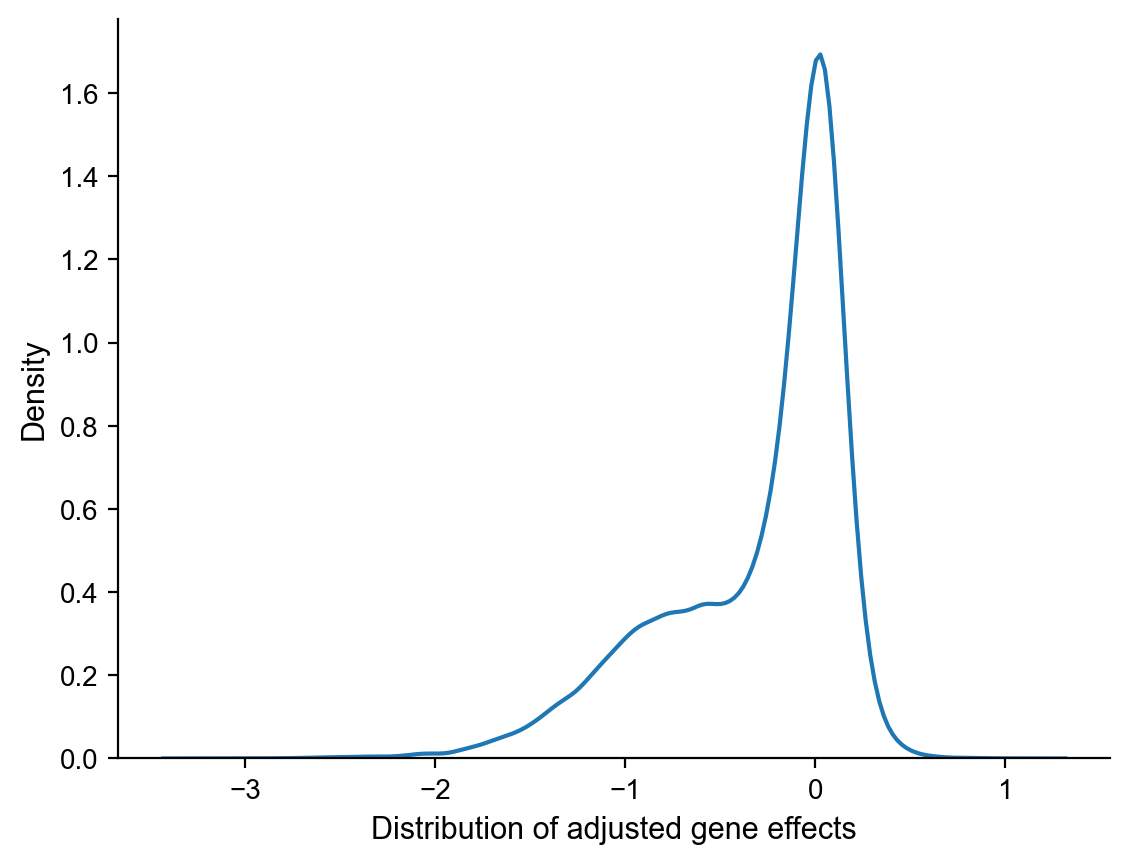

In [26]:
sns.kdeplot(np.ravel(gene_effects))
plt.xlabel("Distribution of adjusted gene effects")

In [27]:
len(set(common_essentials) & set(gene_effects.columns))

320

In [28]:
len(set(nonessentials) & set(gene_effects.columns))

367

### Copy Number Correction

If you have gene-level copy number calls, Chronos includes an option to correct gene effect scores after the fact. This works best if the data has been scaled, as above.

In [29]:
cn = chronos.read_hdf5("Data/SampleData/OmicsCNGene.hdf5")
cn.iloc[:4, :3]

,A1CF (29974),A2M (2),A2ML1 (144568)
ACH-001636,1.110663,1.047670,1.047670
ACH-000784,1.193826,1.161938,1.109943
ACH-000147,1.365585,0.499068,0.499068
ACH-000657,1.033547,1.040547,1.040547


Unfortunately, we don't have copy number calls for one of the genes targeted by the Avana library:

In [30]:
try:
    corrected, shifts = chronos.alternate_CN(gene_effects, cn)
except ValueError as e:
    print(e)

Missing 1 genes from gene_effect in copy_number.
Examples: ['POU2AF3 (120376)']


We could choose to drop these genes. Instead, we'll assume normal ploidy (=1, in the current CCLE convention) for them and fill in the CN matrix accordingly.

In [31]:
for col in set(gene_effects.columns) - set(cn.columns):
    cn[col] = 1

In [32]:
corrected, shifts = chronos.alternate_CN(gene_effects, cn)


Fitting cell line group 1 of 1
finding low CN gene effect shifts
smoothing and interpolating cutting toxicity for all genes
constructed spline matrix of shape 38852, 105
	cost: 0.03970593204285956
	cost: 0.03883143159155688
	cost: 0.03869395820118811
	cost: 0.03860686197076091
	cost: 0.03854619133053345
	cost: 0.03850397615261136
generating matrix


The `shifts` dataframe contains some information about the inferred CN effect, while `corrected` contains the corrected gene effects matrix. Overall, gene effect matrices will change little after correction, since most genes in most lines are near diploid.

We'll write the corrected dataframe to the saved directory we made earlier

In [33]:
chronos.write_hdf5(corrected, os.path.join(savedir, "gene_effect_corrected.hdf5"))

### QC report

The function `dataset_qc_report` in the `reports` module of Chronos presents a variety of QC metrics and interrogates some specific examples. The report minimally requires a set of positive and negative control genes. To get the full report requires copy number, mutation data, expression data, a list of expression addictions (genes which are dependencies in highly expressing lines), and oncogenic mutations.

Below, we'll load an annotated DepMap MAF file (subsetted to our cell lines). We'll select gain of function cancer driver events from it and generate a binary mutation matrix. We have a prior belief that cell lines with driver gain of function mutation events will be dependent on the mutated gene, so this matrix will be used by the QC report to assess our ability to identify selective dependencies. Specifically, we expect the oncogenes in this matrix to be dependencies in cell lines where the matrix is `True`, and not otherwise.

In [34]:
maf = pd.read_csv("Data/SampleData/OmicsSomaticMutations.csv")

In [35]:
cancer_relevant = maf[
  (
      maf.Driver | maf.LikelyDriver  
  ) & (
      maf.LikelyGoF
  )
]


cancer_relevant = cancer_relevant[~cancer_relevant.duplicated(subset=["ModelID", "Gene"])]

cancer_relevant['truecol'] = True

gof_matrix_base = pd.pivot(cancer_relevant, index="ModelID", columns="Gene", values="truecol")

Another way to evaluate selective dependencies is using expression addictions, a common pattern in which a gene is a stronger dependency in lines with higher expression. We'll use a list derived from DepMap RNAi (Tsherniak et al., Cell 2017), and subset our expression matrix to match.

In [36]:
expression_addictions = pd.read_csv("Data/SampleData/RNAiExpressionAddictions.csv")['Gene']

In [37]:
addiction_expressions = chronos.read_hdf5("Data/SampleData/OmicsExpressionProteinCodingGenesTPMLogp1.hdf5")[
    expression_addictions
]

Now, we're ready to run the QC report on Chronos' results:

In [38]:
metrics = reports.dataset_qc_report("ChronosAvana", savedir, 
                          common_essentials, nonessentials,
                          gof_matrix_base, addiction_expressions,
                          cn, directory="Data/reports",
                          gene_effect_file="gene_effect_corrected.hdf5"
                         )

Loading data from Data/Achilles_run_compare
plotting global control separation


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

plotting selective dependency separation


/Users/dempster/packages/chronos_public/chronos/evaluations.py:761: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts = [plt.text(s=neg_means.index[i],x=neg_means[i], y=pos_means[i], fontsize=6, color=[.8, .3, .05]) for i in outliers]


plotting gene effect mean relationships
plotting copy number effect
plotting screen efficacy and growth rate


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


plotting readcount predictions


/Users/dempster/packages/chronos_public/chronos/reports.py:452: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


plotting LFC predictions


/Users/dempster/packages/chronos_public/chronos/reports.py:452: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/reports.py:103: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(data['guide_map'][library].set_index("sgrna").gene, axis=1)\


plotting difference from naive gene score
summarizing
plotting genes with low agreement with naive gene effect
	RFT1 (91869)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for RFT1 (91869), ACH-001736:
avana    av
dtype: object
CCCCACTGAGACATGCTCTG    avGuide1
GCTTGTGCCAAGACCCAAAA    avGuide2
GGAGGCTATGGGCAGCCAGG    avGuide3
GGTGATTGCAGAGAGCCTGT    avGuide4
dtype: object
HB11;19-311CAS9_RepA_p6_Avana-3    avRep1
HB11;19-311CAS9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for RFT1 (91869), ACH-001636:
avana    av
dtype: object
CCCCACTGAGACATGCTCTG    avGuide1
GCTTGTGCCAAGACCCAAAA    avGuide2
GGAGGCTATGGGCAGCCAGG    avGuide3
GGTGATTGCAGAGAGCCTGT    avGuide4
dtype: object
RAMOS-311cas9-RepA-p6_Avana-4    avRep1
RAMOS-311cas9-RepB-p6_Avana-4    avRep2
dtype: object
	BTK (695)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for BTK (695), ACH-001533:
avana    av
dtype: object
AATGATCTACAGCTGCGGAA    avGuide1
ATAGTAGGAGAGTTTGTGCA    avGuide2
CTGTGTTTGCTAAATCCACA    avGuide3
GATGCTCTCCAGAATCACTG    avGuide4
dtype: object
KARPAS1718-311cas9-RepA-p6_Avana-4    avRep1
KARPAS1718-311cas9-RepB-p6_Avana-4    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for BTK (695), ACH-001843:
avana    av
dtype: object
AATGATCTACAGCTGCGGAA    avGuide1
ATAGTAGGAGAGTTTGTGCA    avGuide2
CTGTGTTTGCTAAATCCACA    avGuide3
GATGCTCTCCAGAATCACTG    avGuide4
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	RRP1 (8568)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for RRP1 (8568), ACH-001736:
avana    av
dtype: object
CCTTCTGCAGAATTGCTGCC    avGuide1
CTTCATCGAGATCTTCCTGG    avGuide2
GCAGGTGACCCGGGACCGGG    avGuide3
GCGCCTGGATAAATTCTACA    avGuide4
dtype: object
HB11;19-311CAS9_RepA_p6_Avana-3    avRep1
HB11;19-311CAS9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for RRP1 (8568), ACH-000750:
avana    av
dtype: object
CCTTCTGCAGAATTGCTGCC    avGuide1
CTTCATCGAGATCTTCCTGG    avGuide2
GCAGGTGACCCGGGACCGGG    avGuide3
GCGCCTGGATAAATTCTACA    avGuide4
dtype: object
LOXIMVI-311Cas9_RepA_p6_Avana-2    avRep1
LOXIMVI-311Cas9_RepB_p6_Avana-2    avRep2
dtype: object
	GUCA2A (2980)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for GUCA2A (2980), ACH-000996:
avana    av
dtype: object
CCAGGAGCCCCAGGAGCCCA    avGuide1
GCACAGTGCGGAGAGCAGGA    avGuide2
GGCCCCAAGGAGGCACAGTG    avGuide3
TGGGCTCCTGGGGCTCCTGG    avGuide4
dtype: object
HEC-251-311Cas9_RepA_p5_Avana-3    avRep1
HEC-251-311Cas9_RepB_p5_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for GUCA2A (2980), ACH-001636:
avana    av
dtype: object
CCAGGAGCCCCAGGAGCCCA    avGuide1
GCACAGTGCGGAGAGCAGGA    avGuide2
GGCCCCAAGGAGGCACAGTG    avGuide3
TGGGCTCCTGGGGCTCCTGG    avGuide4
dtype: object
RAMOS-311cas9-RepA-p6_Avana-4    avRep1
RAMOS-311cas9-RepB-p6_Avana-4    avRep2
dtype: object
	ESR1 (2099)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for ESR1 (2099), ACH-000147:
avana    av
dtype: object
CGCCGTGTACAACTACCCCG    avGuide1
GCACCATTGATAAAAACAGG    avGuide2
GTAGACCTGCGCGTTGGCGG    avGuide3
TCGCCTTTCCTGCAGCCCCA    avGuide4
dtype: object
T47D-311Cas9-RepA-p6_Avana-4    avRep1
T47D-311Cas9-RepB-p6_Avana-4    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for ESR1 (2099), ACH-001842:
avana    av
dtype: object
CGCCGTGTACAACTACCCCG    avGuide1
GCACCATTGATAAAAACAGG    avGuide2
GTAGACCTGCGCGTTGGCGG    avGuide3
TCGCCTTTCCTGCAGCCCCA    avGuide4
dtype: object
ICC2-311cas9_RepA_p6_Avana-3    avRep1
ICC2-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	FOXR1 (283150)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for FOXR1 (283150), ACH-000004:
avana    av
dtype: object
GAGACCTCCAGCTTTCCAGG    avGuide1
GGAAGATGCCAGCTGCTCAG    avGuide2
TGAGACCTCCAGCTTTCCAG    avGuide3
TGGGATTTACCCACATCCAG    avGuide4
dtype: object
HEL-311Cas9_RepA_p4_Avana-3    avRep1
HEL-311Cas9_RepB_p4_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for FOXR1 (283150), ACH-000750:
avana    av
dtype: object
GAGACCTCCAGCTTTCCAGG    avGuide1
GGAAGATGCCAGCTGCTCAG    avGuide2
TGAGACCTCCAGCTTTCCAG    avGuide3
TGGGATTTACCCACATCCAG    avGuide4
dtype: object
LOXIMVI-311Cas9_RepA_p6_Avana-2    avRep1
LOXIMVI-311Cas9_RepB_p6_Avana-2    avRep2
dtype: object
	PFDN2 (5202)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for PFDN2 (5202), ACH-000988:
avana    av
dtype: object
AACTCGTAAGTGCTACCGCA    avGuide1
CCAGCACTCCTCCAACCATG    avGuide2
GCGAAGATGGCGGAGAACAG    avGuide3
GGTCGCGCCGGCAAGAGCAG    avGuide4
dtype: object
MFE-319-311Cas9_RepA_p6_Avana-3    avRep1
MFE-319-311Cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for PFDN2 (5202), ACH-000912:
avana    av
dtype: object
AACTCGTAAGTGCTACCGCA    avGuide1
CCAGCACTCCTCCAACCATG    avGuide2
GCGAAGATGGCGGAGAACAG    avGuide3
GGTCGCGCCGGCAAGAGCAG    avGuide4
dtype: object
NCI-H2286-311caa9_RepA_p6_Avana-3    avRep1
NCI-H2286-311caa9_RepB_p6_Avana-3    avRep2
dtype: object
	MCM6 (4175)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for MCM6 (4175), ACH-000787:
avana    av
dtype: object
GGCAATGATGAAGTAAAACG    avGuide1
GTTCACCCAGAGCTTGTGAG    avGuide2
TCAAGGCCCGACACAGGTAA    avGuide3
TGTTGCGCCAACCAACCCAA    avGuide4
dtype: object
LXF-289-311cas9 Rep B p6_Avana-3    avRep1
LXF-289-311cas9 Rep C p6_Avana-3    avRep2
LXF-289-311cas9 Rep D p6_Avana-3    avRep3
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for MCM6 (4175), ACH-000750:
avana    av
dtype: object
GGCAATGATGAAGTAAAACG    avGuide1
GTTCACCCAGAGCTTGTGAG    avGuide2
TCAAGGCCCGACACAGGTAA    avGuide3
TGTTGCGCCAACCAACCCAA    avGuide4
dtype: object
LOXIMVI-311Cas9_RepA_p6_Avana-2    avRep1
LOXIMVI-311Cas9_RepB_p6_Avana-2    avRep2
dtype: object
	NEDD1 (121441)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for NEDD1 (121441), ACH-000988:
avana    av
dtype: object
GGCTGACACTCCTCTAACTG    avGuide1
TAGAACTGTGGCAATGGACG    avGuide2
TCTATGTATTTGGTAAGCGG    avGuide3
TGGCTATTGGATCTTCCCGG    avGuide4
dtype: object
MFE-319-311Cas9_RepA_p6_Avana-3    avRep1
MFE-319-311Cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for NEDD1 (121441), ACH-000912:
avana    av
dtype: object
GGCTGACACTCCTCTAACTG    avGuide1
TAGAACTGTGGCAATGGACG    avGuide2
TCTATGTATTTGGTAAGCGG    avGuide3
TGGCTATTGGATCTTCCCGG    avGuide4
dtype: object
NCI-H2286-311caa9_RepA_p6_Avana-3    avRep1
NCI-H2286-311caa9_RepB_p6_Avana-3    avRep2
dtype: object
	NIP7 (51388)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for NIP7 (51388), ACH-001303:
avana    av
dtype: object
CTTGTCCCCGGAAATATTGG    avGuide1
GCTGGCCGCCAATATTTCCG    avGuide2
GTTTCCGTCTGCACAACGAC    avGuide3
TATCTTCTCAAACATGACAC    avGuide4
dtype: object
NB1643-311Cas9_RepA_p4_Avana-3    avRep1
NB1643-311Cas9_RepB_p4_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for NIP7 (51388), ACH-000912:
avana    av
dtype: object
CTTGTCCCCGGAAATATTGG    avGuide1
GCTGGCCGCCAATATTTCCG    avGuide2
GTTTCCGTCTGCACAACGAC    avGuide3
TATCTTCTCAAACATGACAC    avGuide4
dtype: object
NCI-H2286-311caa9_RepA_p6_Avana-3    avRep1
NCI-H2286-311caa9_RepB_p6_Avana-3    avRep2
dtype: object
	NOL11 (25926)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for NOL11 (25926), ACH-000396:
avana    av
dtype: object
CAGTTTCTAGTGACAGACAG    avGuide1
CCTTCCTTGAAGAGCACCAA    avGuide2
TTACCCTTAGAAGCTGCTAG    avGuide3
TTCACTGACCAGCTCCCCAA    avGuide4
dtype: object
J82-311Cas9_RepA_p5_Avana-3    avRep1
J82-311Cas9_RepB_p5_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for NOL11 (25926), ACH-000750:
avana    av
dtype: object
CAGTTTCTAGTGACAGACAG    avGuide1
CCTTCCTTGAAGAGCACCAA    avGuide2
TTACCCTTAGAAGCTGCTAG    avGuide3
TTCACTGACCAGCTCCCCAA    avGuide4
dtype: object
LOXIMVI-311Cas9_RepA_p6_Avana-2    avRep1
LOXIMVI-311Cas9_RepB_p6_Avana-2    avRep2
dtype: object
	SCFD1 (23256)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for SCFD1 (23256), ACH-001129:
avana    av
dtype: object
ACTAGAATCTTACAGAGCAC    avGuide1
CTAGGATTTCCATTTAAACA    avGuide2
GAAGTCTTATGATTTAACTC    avGuide3
GGAGTGGAAAACTCTCCAGC    avGuide4
dtype: object
MONO-MAC1-311cas9_RepA_p6_Avana-3    avRep1
MONO-MAC1-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for SCFD1 (23256), ACH-000074:
avana    av
dtype: object
ACTAGAATCTTACAGAGCAC    avGuide1
CTAGGATTTCCATTTAAACA    avGuide2
GAAGTCTTATGATTTAACTC    avGuide3
GGAGTGGAAAACTCTCCAGC    avGuide4
dtype: object
KU812-311cas9-RepA-p6_Avana-3    avRep1
KU812-311cas9-RepB-p6_Avana-3    avRep2
dtype: object
	POU2AF3 (120376)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for POU2AF3 (120376), ACH-001843:
avana    av
dtype: object
CTTTGTGTGGAATTGAGCAA    avGuide1
GCTCTGGTTAAAGCAGAAAG    avGuide2
TCTGGTGTCCAGAGAAGCAG    avGuide3
TTCTGGTGTCCAGAGAAGCA    avGuide4
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for POU2AF3 (120376), ACH-000750:
avana    av
dtype: object
CTTTGTGTGGAATTGAGCAA    avGuide1
GCTCTGGTTAAAGCAGAAAG    avGuide2
TCTGGTGTCCAGAGAAGCAG    avGuide3
TTCTGGTGTCCAGAGAAGCA    avGuide4
dtype: object
LOXIMVI-311Cas9_RepA_p6_Avana-2    avRep1
LOXIMVI-311Cas9_RepB_p6_Avana-2    avRep2
dtype: object
	FOXA1 (3169)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for FOXA1 (3169), ACH-000147:
avana    av
dtype: object
GCAGTAGCCGGCATGCCGGG    avGuide1
GCTCATGCACGGGTTCATGG    avGuide2
GGACATGTTGAAGGACGCCG    avGuide3
GGTACGGCGCTGAGCCCGAG    avGuide4
dtype: object
T47D-311Cas9-RepA-p6_Avana-4    avRep1
T47D-311Cas9-RepB-p6_Avana-4    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for FOXA1 (3169), ACH-000479:
avana    av
dtype: object
GCAGTAGCCGGCATGCCGGG    avGuide1
GCTCATGCACGGGTTCATGG    avGuide2
GGACATGTTGAAGGACGCCG    avGuide3
GGTACGGCGCTGAGCCCGAG    avGuide4
dtype: object
KNS-81-311cas9_RepA_p5_Avana-3    avRep1
KNS-81-311cas9_RepB_p5_Avana-3    avRep2
dtype: object
	TNPO3 (23534)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for TNPO3 (23534), ACH-000935:
avana    av
dtype: object
CCAGTTGTTACAGATCCGGC    avGuide1
GACTGCCTATCATATGGCCG    avGuide2
TACCACGACCCAGATCCCAG    avGuide3
TTACATGGTCTGGTTCCAGC    avGuide4
dtype: object
MDST8-311Cas9 Rep A p6_Avana-3    avRep1
MDST8-311Cas9 Rep C p6_Avana-3    avRep2
MDST8-311Cas9 Rep D p6_Avana-3    avRep3
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for TNPO3 (23534), ACH-000527:
avana    av
dtype: object
CCAGTTGTTACAGATCCGGC    avGuide1
GACTGCCTATCATATGGCCG    avGuide2
TACCACGACCCAGATCCCAG    avGuide3
TTACATGGTCTGGTTCCAGC    avGuide4
dtype: object
OVISE-311cas9 Rep A p6_Avana-2    avRep1
OVISE-311cas9 Rep B p6_Avana-2    avRep2
OVISE-311cas9 Rep C p6_Avana-2    avRep3
dtype: object
	JAK2 (3717)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for JAK2 (3717), ACH-000004:
avana    av
dtype: object
ATAATCATACCTGAGCAAAG    avGuide1
ATCTGCCTCAGATTTCCCAA    avGuide2
CTGCCACTGCAATACCAACG    avGuide3
GAGGTGCTACTTCTTTACAG    avGuide4
dtype: object
HEL-311Cas9_RepA_p4_Avana-3    avRep1
HEL-311Cas9_RepB_p4_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for JAK2 (3717), ACH-000396:
avana    av
dtype: object
ATAATCATACCTGAGCAAAG    avGuide1
ATCTGCCTCAGATTTCCCAA    avGuide2
CTGCCACTGCAATACCAACG    avGuide3
GAGGTGCTACTTCTTTACAG    avGuide4
dtype: object
J82-311Cas9_RepA_p5_Avana-3    avRep1
J82-311Cas9_RepB_p5_Avana-3    avRep2
dtype: object
	PRMT5 (10419)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for PRMT5 (10419), ACH-000988:
avana    av
dtype: object
ATGAACTCCCTCTTGAAACG    avGuide1
CTAGTCATCCCGGAGAAGCA    avGuide2
GGAGAAAAACCCAAATGCCG    avGuide3
GGTTGCTACTCACGTCACCA    avGuide4
dtype: object
MFE-319-311Cas9_RepA_p6_Avana-3    avRep1
MFE-319-311Cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for PRMT5 (10419), ACH-000935:
avana    av
dtype: object
ATGAACTCCCTCTTGAAACG    avGuide1
CTAGTCATCCCGGAGAAGCA    avGuide2
GGAGAAAAACCCAAATGCCG    avGuide3
GGTTGCTACTCACGTCACCA    avGuide4
dtype: object
MDST8-311Cas9 Rep A p6_Avana-3    avRep1
MDST8-311Cas9 Rep C p6_Avana-3    avRep2
MDST8-311Cas9 Rep D p6_Avana-3    avRep3
dtype: object
	JAK3 (3718)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for JAK3 (3718), ACH-000406:
avana    av
dtype: object
GGAAGCTGTCAAAGTCCTGG    avGuide1
GGAGCGGCTGGATCCAGCCG    avGuide2
TCCTTCACCAAGATTTACCG    avGuide3
TGCCGCCGTCACCAGCCACG    avGuide4
dtype: object
U937-101Cas9 Rep A p6_Avana-3    avRep1
U937-101Cas9 Rep C p6_Avana-3    avRep2
U937-101Cas9 Rep D p6_Avana-3    avRep3
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for JAK3 (3718), ACH-000479:
avana    av
dtype: object
GGAAGCTGTCAAAGTCCTGG    avGuide1
GGAGCGGCTGGATCCAGCCG    avGuide2
TCCTTCACCAAGATTTACCG    avGuide3
TGCCGCCGTCACCAGCCACG    avGuide4
dtype: object
KNS-81-311cas9_RepA_p5_Avana-3    avRep1
KNS-81-311cas9_RepB_p5_Avana-3    avRep2
dtype: object
	CLEC2A (387836)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for CLEC2A (387836), ACH-000004:
avana    av
dtype: object
ATTAATCCAGAGCTGCGGGA    avGuide1
CCATGATTAATCCAGAGCTG    avGuide2
GAGCTGATGGCTTCATACAT    avGuide3
GATGGCTTCATACATCGGAT    avGuide4
dtype: object
HEL-311Cas9_RepA_p4_Avana-3    avRep1
HEL-311Cas9_RepB_p4_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for CLEC2A (387836), ACH-001636:
avana    av
dtype: object
ATTAATCCAGAGCTGCGGGA    avGuide1
CCATGATTAATCCAGAGCTG    avGuide2
GAGCTGATGGCTTCATACAT    avGuide3
GATGGCTTCATACATCGGAT    avGuide4
dtype: object
RAMOS-311cas9-RepA-p6_Avana-4    avRep1
RAMOS-311cas9-RepB-p6_Avana-4    avRep2
dtype: object
	TSR2 (90121)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for TSR2 (90121), ACH-000937:
avana    av
dtype: object
ACAGCCAGGAGAAGGCCAAG    avGuide1
CCTGTGTTTACAGATCGCTG    avGuide2
CGTTGGTCAACAGCTCTCCA    avGuide3
TTTCCGGGCTGGGGTCTGCG    avGuide4
dtype: object
PF382-311CAS9_RepA_p6_Avana-3    avRep1
PF382-311CAS9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for TSR2 (90121), ACH-000263:
avana    av
dtype: object
ACAGCCAGGAGAAGGCCAAG    avGuide1
CCTGTGTTTACAGATCGCTG    avGuide2
CGTTGGTCAACAGCTCTCCA    avGuide3
TTTCCGGGCTGGGGTCTGCG    avGuide4
dtype: object
KASUMI-1-311cas9_RepA_p6_Avana-3    avRep1
KASUMI-1-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
building report


## Identifying Hits

You may be interested in getting a list of genes that are true dependencies in your screen. Chronos provides two methods to do this:

- Given a set of negative control genes (or a boolean matrix of individual genes within specific cell lines that are negative controls, such as a matrix of unexpressed genes), Chronos can compute empirical p-values for the null hypothesis that the KO had no viability effect against the alternative hypothesis that it caused loss of viability
-  Given a set of positive and negative control genes, Chronos can estimate the probability that a given gene effect score came from the distribution of positive controls vs negative controls. If the controls are representative of essential/nonessential genes, then the probability tells you how likely it is that a given score represents an essential gene for that cell line. 

To get an unbiased estimate, is important not to use CRISPR results from the same library to choose or refine the control sets. We want the scores for the gene sets to capture any bias or artifacts present in CRISPR.

In [39]:
from chronos.hit_calling import get_probability_dependent, get_pvalue_dependent

In [40]:
pvalues = get_pvalue_dependent(corrected, nonessentials)

/Users/dempster/packages/chronos_public/chronos/hit_calling.py:939: UserWarning: Not all negative_controls found in the gene effect columns: ['PRB4 (5545)', 'KRTAP10-6 (386674)', 'KRTAP9-2 (83899)', 'S100A7A (338324)', 'KRTAP9-4 (85280)']
  warn("Not all %s found in the gene effect columns: %r" % (label, missing[:5]))


In [41]:
probabilities = get_probability_dependent(corrected, nonessentials, common_essentials)

/Users/dempster/packages/chronos_public/chronos/hit_calling.py:939: UserWarning: Not all positive controls found in the gene effect columns: ['WDR70 (55100)', 'RPL23A (6147)', 'RPL7L1 (285855)']
  warn("Not all %s found in the gene effect columns: %r" % (label, missing[:5]))
/Users/dempster/packages/chronos_public/chronos/hit_calling.py:939: UserWarning: Not all negative controls found in the gene effect columns: ['PRB4 (5545)', 'KRTAP10-6 (386674)', 'KRTAP9-2 (83899)', 'S100A7A (338324)', 'KRTAP9-4 (85280)']
  warn("Not all %s found in the gene effect columns: %r" % (label, missing[:5]))


Converged at likelihood 101.721170 with 29 iterations
Converged at likelihood 77.823965 with 27 iterations
Converged at likelihood 186.475028 with 23 iterations
Converged at likelihood 89.665431 with 35 iterations
Converged at likelihood 140.089706 with 21 iterations
Converged at likelihood 67.644624 with 41 iterations
Converged at likelihood 114.623871 with 25 iterations
Converged at likelihood 91.732520 with 39 iterations
Converged at likelihood 46.037753 with 41 iterations
Converged at likelihood 79.046400 with 29 iterations
Converged at likelihood 228.379441 with 17 iterations
Converged at likelihood 125.148742 with 30 iterations
Converged at likelihood 141.409187 with 21 iterations
Converged at likelihood 58.790465 with 43 iterations
Converged at likelihood 223.571499 with 16 iterations
Converged at likelihood 118.110145 with 29 iterations
Converged at likelihood 149.789678 with 26 iterations
Converged at likelihood 167.650574 with 20 iterations
Converged at likelihood 6.965509 wi

Each of these has advantages and disadvantages for hit-calling. The probability of dependency is highly dependent on choosing a set of positive controls that accurately capture the distribution of gene-loss-driven depleting phenotypes in your screen. Too stringent a list will cause underestimates, while too loose a list will lead to failure control false discovery. The inverse is true of the negative controls, but it is often possible to identify a very rigorous and representative set of negative controls using unexpressed genes. You should plot the distributions of all your gene effect scores, your negative controls, and your positive controls to see if the positive controls really do represent the left tail:

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Gene Effect')

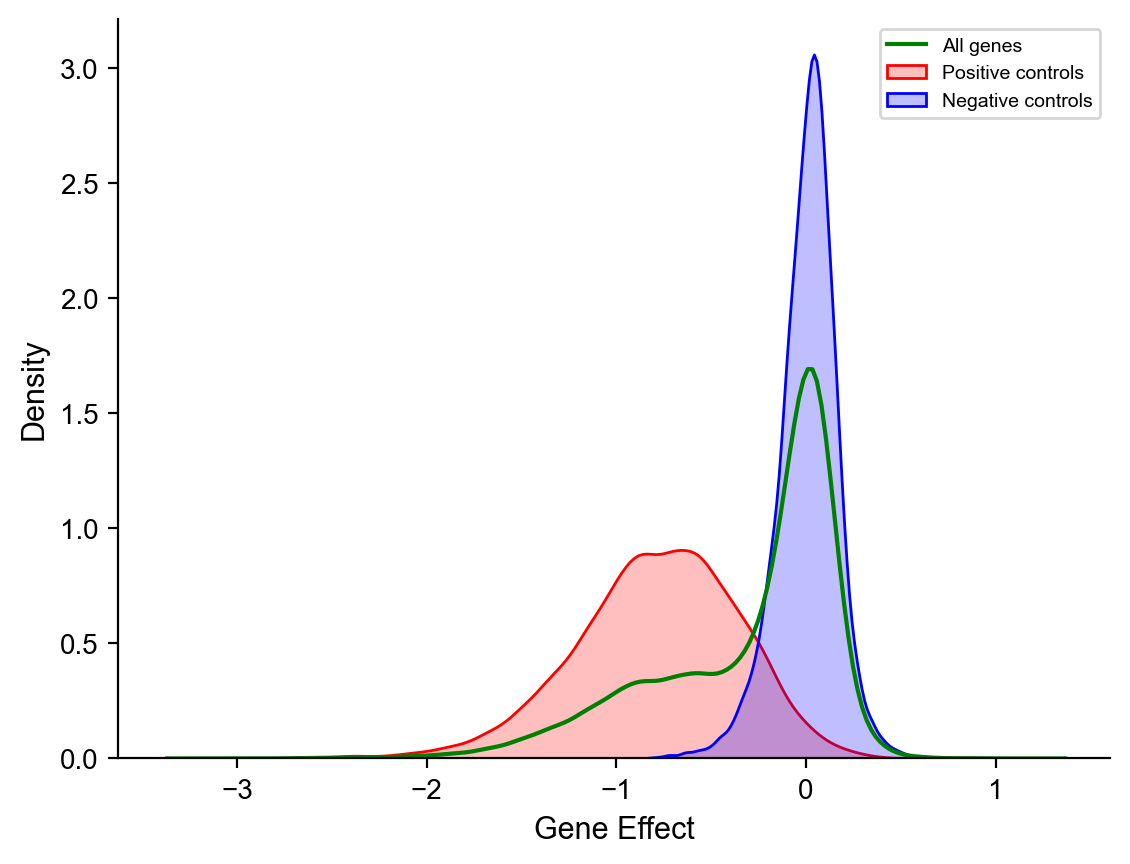

In [42]:
sns.kdeplot(np.ravel(corrected), label="All genes", color="green")
sns.kdeplot(np.ravel(corrected.reindex(columns=common_essentials)), label="Positive controls", color="red", fill=True)
sns.kdeplot(np.ravel(corrected.reindex(columns=nonessentials)), label="Negative controls", color="blue", fill=True)
plt.legend()
plt.xlabel("Gene Effect")

On the other hand, the power of the empirical p-values will be strictly limited by the number of negative controls. In fact, the minimum possible _p_ that can be achieved is 1 / len(negative_controls). This is likely to be an issue in a subgenome library. Below, we see the effect of this cap on significance:

Text(0, 0.5, '-Log10 P')

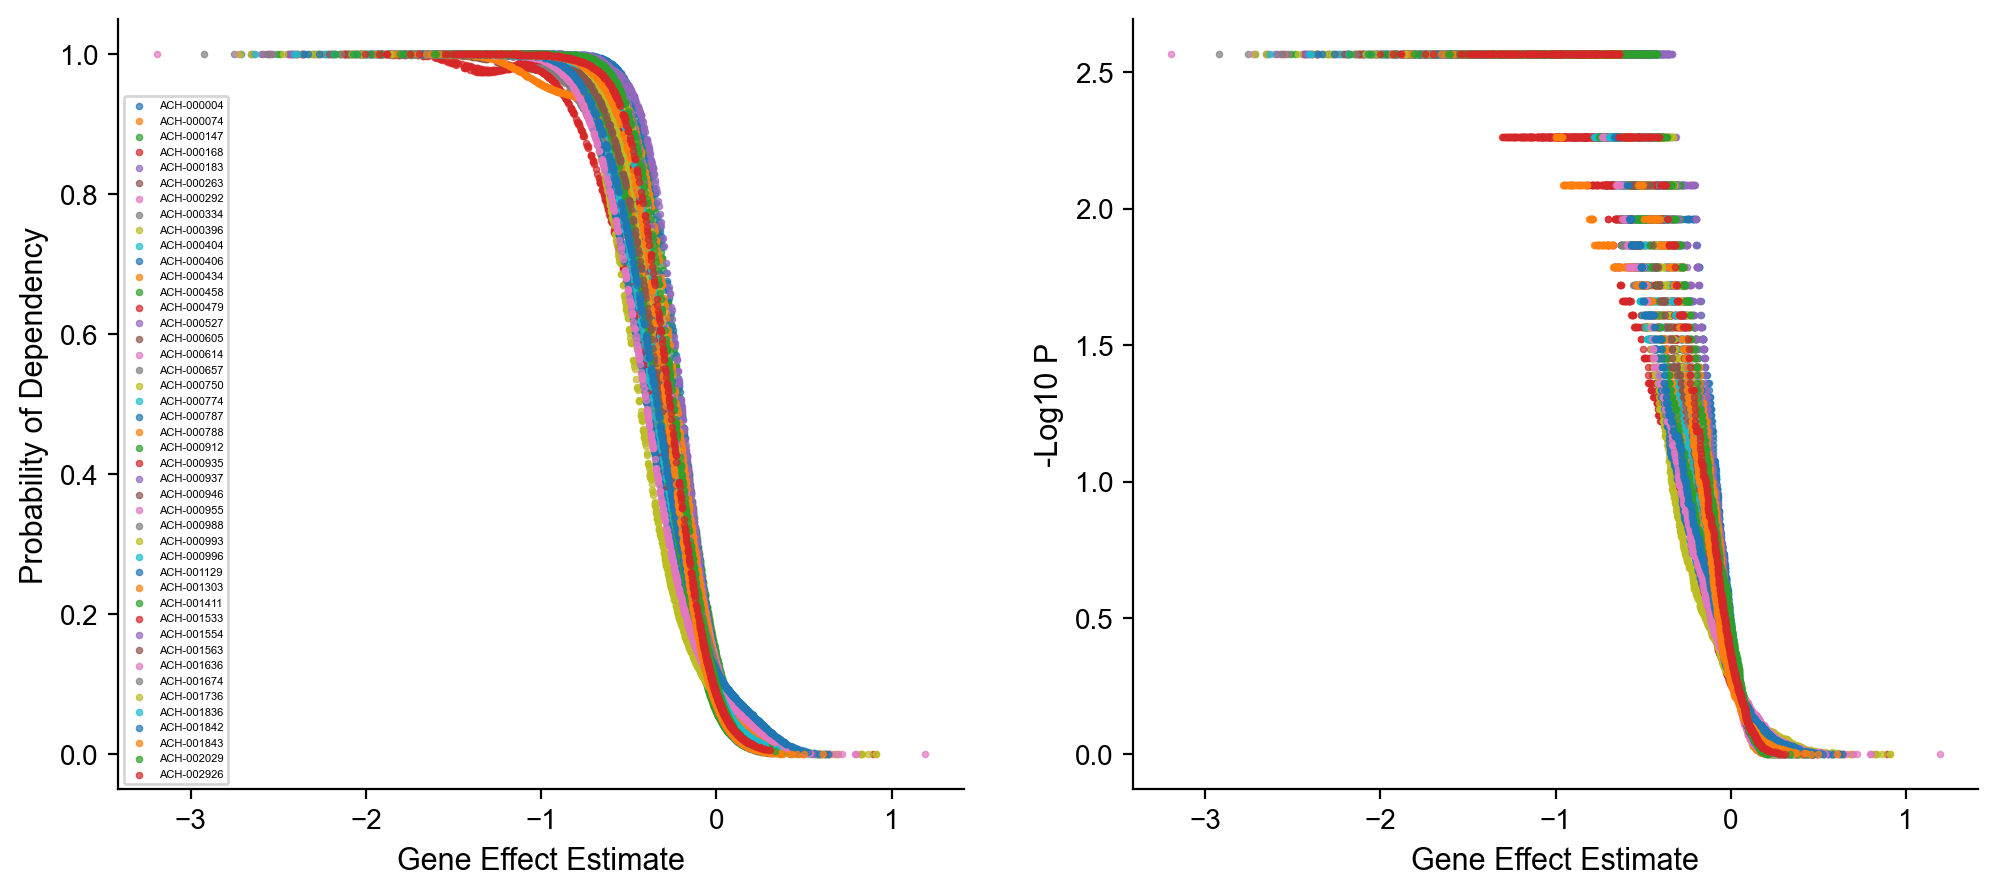

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plt.sca(axes[0])
for ind in probabilities.index:
    plt.scatter(corrected.loc[ind], probabilities.loc[ind], s=5, alpha=.7, linewidth=.5, label=ind)
plt.legend(fontsize=4, loc="lower left")
plt.xlabel("Gene Effect Estimate")
plt.ylabel("Probability of Dependency")

plt.sca(axes[1])
for ind in pvalues.index:
    plt.scatter(corrected.loc[ind], -np.log10(pvalues.loc[ind]), s=5, alpha=.7, linewidth=.5, label=ind)
plt.xlabel("Gene Effect Estimate")
plt.ylabel("-Log10 P")

We can make a roughly head-to-head comparison of discoveries from the two methods by estimating a false discovery rate using each. Using p-values for many hypotheses, false discovery is typically controlled with the Benjamini-Hochberg procedure. This is a frequentist FDR. In contrast, using probabilities of dependency, we can directly estimate the Bayesian FDR: the number of true discoveries below a threshold is just the sum of the probabilities of dependency. See https://arxiv.org/pdf/1803.05284.pdf for a discussion of frequentist and Bayesian false discovery.

In [44]:
from chronos.hit_calling import get_fdr_from_probabilities, get_fdr_from_pvalues
fdr_from_probabilities = get_fdr_from_probabilities(probabilities)
fdr_from_pvalues = get_fdr_from_pvalues(pvalues)

We'll do a quick, nonrigorous calibration check, considering only the control sets:

In [45]:
def calibration_check(fdr, positive_controls, negative_controls):
    controls_only = fdr\
    .reindex(columns=list(positive_controls) + list(negative_controls))\
    .dropna(axis=1)

    is_essential = pd.DataFrame(
        np.repeat(
            controls_only.columns.isin(positive_controls).reshape(1, -1), 
            len(controls_only), axis=0
        ),
       index=controls_only.index,
        columns=controls_only.columns
    )
    
    calibration = pd.DataFrame({
        "FDR": np.ravel(controls_only),
        "IsTrue": np.ravel(is_essential)
    }).sort_values("FDR")
    calibration["ProportionFalse"] = np.cumsum(~calibration.IsTrue) / np.arange(1, len(calibration)+1)
    
    return calibration

In [46]:
calibration_probabilities = calibration_check(fdr_from_probabilities, common_essentials, nonessentials)
calibration_pvalues = calibration_check(fdr_from_pvalues, common_essentials, nonessentials)

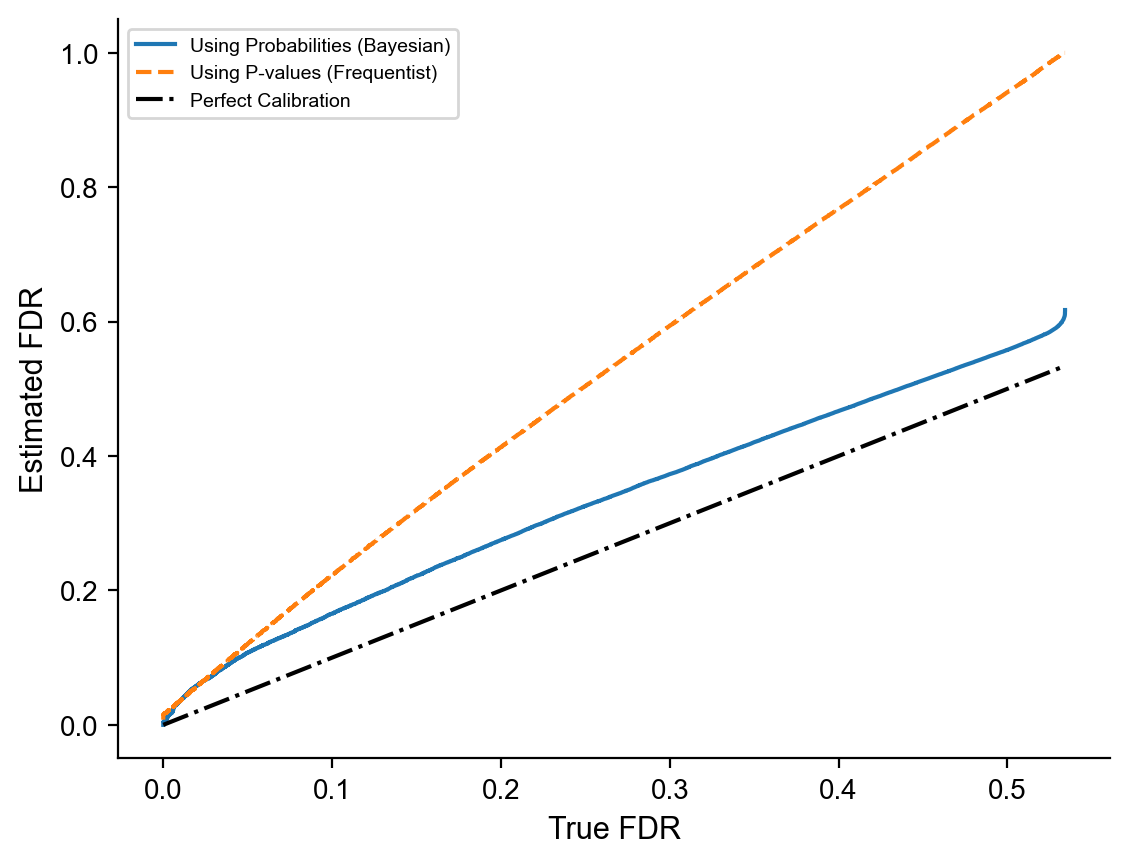

In [47]:
plt.plot(
    calibration_probabilities["ProportionFalse"],
    calibration_probabilities["FDR"],
    label="Using Probabilities (Bayesian)"
)

plt.plot(
    calibration_pvalues["ProportionFalse"],
    calibration_pvalues["FDR"],
    '--', 
    label="Using P-values (Frequentist)"
)

max_fdr = calibration_probabilities.ProportionFalse.max()
plt.plot([0, max_fdr], [0, max_fdr], '-.', color="black", label="Perfect Calibration")

plt.ylabel("Estimated FDR")
plt.xlabel("True FDR")
plt.legend()

We can see that both estimates of FDR are conservative, which is surely preferable to being optimistic. This may be partly due to the presence of the noncontrol genes in the full data, which have a lower proportion of true dependencies than the controls and affect the FDR estimates in the controls. The probability based method has an unfair advantage as it as seen the same set of positive controls as well as the negative controls. To be truly rigorous we would need to split the controls used in training and in evaluating calibration, and run Chronos without any non-control genes. 

Note that the BH estimates reach 1, while probability-based estimates saturate below 1. This is because the BH procedure assumes the proportion of true discoveries is approximately 0 over the whole dataset:

In [48]:
fdr_from_pvalues.max().max(), fdr_from_pvalues.max(axis=1).mean()

(1.0, 1.0)

In [49]:
fdr_from_probabilities.max(axis=1).max(), fdr_from_probabilities.max(axis=1).mean()

(0.6181453128019082, 0.5910175635392401)

If an estimated FDR is correct, 1- the maximum FDR for a cell line should be equal to the fraction of true dependencies in that cell line. The lowest probability-based estimate of 0.38 is close to the proportion of common essential genes in the dataset (0.36), illustrating the greater power of the FDRs computed this way. When we compute FDRs from p-values using the Benjamini-Hochberg procedure, we are estimating adjusted p-values to _control_ false discovery rather than the true FDR, and the adjusted p-values reach 1.

We should also note that having a large number of true dependencies our test library improves the apparent performance of the frequentist method, because it allows values to remain significant after the BH procedure. In a setting with few true dependencies, the frequentist method may become severely underpowered.

Summing up: using `get_probability_dependent` is more powerful, and especially so in the case of subgenome libraries with limited negative control sets and a modest proportion of true hits. However, it requires correctly specifying the positive control distribution by identifying _representative_ positive control genes independently from your screening data (ideally, independent of any CRISPR data). 

## Running with multiple libraries

We can add Sanger's [Project Score](https://www.nature.com/articles/s41586-019-1103-9) data (screened with the KY library) and run Chronos jointly on it and the Avana data. 

In [50]:
ky_guide_map = pd.read_csv("./Data/SampleData/KYGuideMap.csv")
ky_sequence_map = pd.read_csv("./Data/SampleData/KYSequenceMap.csv")
ky_readcounts = chronos.read_hdf5("./Data/SampleData/KYReadcounts.hdf5")

In [51]:
ky_positive_controls = ky_guide_map.sgrna[ky_guide_map.gene.isin(common_essentials)]
ky_negative_controls = ky_guide_map.sgrna[ky_guide_map.gene.isin(nonessentials)]

Note how the call signature of Chronos with multiple libraries is constructed:

In [52]:
model2 = chronos.Chronos(
    sequence_map={"avana": sequence_map, 'ky': ky_sequence_map},
    guide_gene_map={"avana": guide_map, 'ky': ky_guide_map},
    readcounts={"avana": readcounts, 'ky': ky_readcounts},
    negative_control_sgrnas={"avana": negative_controls, "ky": ky_negative_controls}
)

normalizing readcounts


Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 4084 unique guides and 833 unique genes in ky
found 7558 unique guides and 887 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA) and 44 unique cell lines in avana
found 63 unique sequences (excluding pDNA) and 23 unique cell lines in ky
found 155 unique replicates and 58 unique cell lines overall

finding replicate-cell line mappings indices

finding replicate-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
Between 0 (batch=Index(['avana_Avana-2', 'avana_Avana-3', 'avana_Avana-4'], dtype='object')) and 0 (batch=Index(['avana_Avana-2', 'avana_Avana-3', 'avana_Avana-4'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented 

/Users/dempster/packages/chronos_public/chronos/model.py:1222: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\
/Users/dempster/packages/chronos_public/chronos/model.py:1222: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\


	built normalized timepoints for avana with shape (92, 3474) (replicates X guides)
	built normalized timepoints for ky with shape (63, 4084) (replicates X guides)

building t0 reads


Building variables

building t0 reads estimate
made t0 batch with shape (2, 4084) for avana
made t0 batch with shape (2, 4084) for ky
building guide efficacy
built guide efficacy: shape [1, 7559]
building growth rate
built growth rate: shape {'avana': [58, 1], 'ky': [58, 1]}

building cell line efficacy
built cell line efficacy: shapes {'avana': [58, 1], 'ky': [58, 1]}
building screen delay
built screen delay
building gene effect
built core gene effect: 58 cell lines by 887 genes


Connecting graph nodes in model

building effective days
built effective days, shapes {'avana': [92, 887], 'ky': [63, 887]}

building gene effect growth graph nodes
built gene effect growth graph nodes, shapes {'avana': [58, 887], 'ky': [58, 887]}

building combined efficacy
built combined efficacy, shape {'avana': [58, 3474], 

2024-02-01 13:33:43.219159: W tensorflow/c/c_api.cc:304] Operation '{name:'inferred_t0_2/base_avana/Assign' id:6376 op device:{requested: '', assigned: ''} def:{{{node inferred_t0_2/base_avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](inferred_t0_2/base_avana, inferred_t0_2/base_avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


building other regularizations

Creating optimizer
initializing rest of graph


2024-02-01 13:33:44.365650: W tensorflow/c/c_api.cc:304] Operation '{name:'GE_2/library_effect/ky/Assign' id:6591 op device:{requested: '', assigned: ''} def:{{{node GE_2/library_effect/ky/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_2/library_effect/ky, GE_2/library_effect/ky/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


estimating initial screen efficacy and gene effect
	 avana
	 ky


/Users/dempster/packages/chronos_public/chronos/model.py:1828: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map.set_index("sgrna").gene, axis=1)\
/Users/dempster/packages/chronos_public/chronos/model.py:1828: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map.set_index("sgrna").gene, axis=1)\


	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	avana _gene_effect
	avana _selected_efficacies
	avana_predicted_readcounts_unscaled
	avana _predicted_readcounts
	avana _normalized_readcounts
	avana _cost_presum
sess run
	avana _cost
	avana _full_costs
	ky _gene_effect
	ky _selected_efficacies
	ky_predicted_readcounts_unscaled
	ky _predicted_readcounts
	ky _normalized_readcounts
	ky _cost_presum
sess run
	ky _cost
	ky _full_costs
ready to train


In [53]:
model2.train(301)

NB2 cost 0.36044767878187667
Full cost 0.5079895729474396
relative_growth_rate
	avana max 1.053, min 0.94522
	ky max 1.039, min 0.94926
mean guide efficacy 0.9991983881119243
t0_offset SD: [('avana', 7.041252890176513e-05), ('ky', 7.560844538928017e-05)]

gene mean -0.2629519503957272
SD of gene means 0.4288012408639532
Mean of gene SDs 0.3400880715479724



51 epochs trained, time taken 0:00:03, projected remaining 0:00:14
NB2 cost 0.2546204719574362
Full cost 0.3154434883596054
relative_growth_rate
	avana max 1.237, min 0.50080
	ky max 1.498, min 0.50444
mean guide efficacy 0.9361690944456519
t0_offset SD: [('avana', 0.1398597901519874), ('ky', 0.13665546794816816)]

gene mean -0.010620712342198716
SD of gene means 0.5331837446435761
Mean of gene SDs 0.27074619349005313



101 epochs trained, time taken 0:00:05, projected remaining 0:00:10
NB2 cost 0.23523377349236693
Full cost 0.25896247649201
relative_growth_rate
	avana max 1.558, min 0.45130
	ky max 1.258, min 0.68204
mean guide e

Note that the gene effect now has NAs. These are cases where a cell line was only screened in one library and that library had no guides for that gene.

Chronos infers library batch effects. Note that these are only inferred for genes present in all libraries

In [54]:
model2.library_effect

library,avana,ky
gene,,
A1CF (29974),-0.186442,0.150060
A2M (2),-0.288799,0.232443
A2ML1 (144568),-0.213286,0.171666
A3GALT2 (127550),-0.092445,0.074405
A4GALT (53947),-0.171986,0.138425
...,...,...
ZNF622 (90441),-0.227152,0.182825
ZNF648 (127665),-0.187112,0.150599
ZNF804B (219578),-0.294177,0.236771


## Running your screen with pretrained DepMap parameters

If you conducted a screen in one of the DepMap integrated libraries (currently Avana, KY, or Humagne-CD), you can load parameters from the trained DepMap model and use them to process your specific screen. This gives you many of the benefits of coprocessing your screen with the complete DepMap dataset without the computational expense. 

The following command fetches the 23Q4 public dataset from Figshare and stores it in the Chronos package directory under Data/DepMapParameters

In [55]:
chronos.fetch_parameters()

`url_loc` will be found relative to the chronos package directory
'/Users/dempster/packages/chronos_public/chronos'
Pass `relative_to_chronos=False` to make the path relative to your current working directory
'/Users/dempster/packages/chronos_public'
instead.

`output_dir` will be found relative to the chronos package directory
'/Users/dempster/packages/chronos_public/chronos'
Pass `relative_to_chronos=False` to make the path relative to your current working directory
'/Users/dempster/packages/chronos_public'
instead.

downloading files to /Users/dempster/packages/chronos_public/chronos/../Data/DepMapParameters/
Skipping gene_effect.csv as it already exists, pass `overwrite=True` to overwrite
Skipping guide_efficacy.csv as it already exists, pass `overwrite=True` to overwrite
Skipping cell_line_efficacy.csv as it already exists, pass `overwrite=True` to overwrite
Skipping library_effect.csv as it already exists, pass `overwrite=True` to overwrite
Skipping t0_offset.csv as it already ex

First, we create a model with the data we want to train as before, but with two important details:
- we pass the argument `pretrained=True` when we initialize
- the library batch names must match the DepMap library batch names, as that's what we're using for the pretrained model

In [56]:
model2_pretrained = chronos.Chronos(
    sequence_map={"Achilles-Avana-2D": sequence_map, 'Achilles-KY-2D': ky_sequence_map},
    guide_gene_map={"Achilles-Avana-2D": guide_map, 'Achilles-KY-2D': ky_guide_map},
    readcounts={"Achilles-Avana-2D": readcounts, 'Achilles-KY-2D': ky_readcounts},
    negative_control_sgrnas={"Achilles-Avana-2D": negative_controls, "Achilles-KY-2D": ky_negative_controls},
    pretrained=True
)

normalizing readcounts


Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in Achilles-Avana-2D
found 4084 unique guides and 833 unique genes in Achilles-KY-2D
found 7558 unique guides and 887 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA) and 44 unique cell lines in Achilles-Avana-2D
found 63 unique sequences (excluding pDNA) and 23 unique cell lines in Achilles-KY-2D
found 155 unique replicates and 58 unique cell lines overall

finding replicate-cell line mappings indices

finding replicate-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for Achilles-Avana-2D
Between 0 (batch=Index(['Achilles-Avana-2D_Avana-2', 'Achilles-Avana-2D_Avana-3',
       'Achilles-Avana-2D_Avana-4'],
      dtype='object')) and 0 (batch=Index(['Achilles-Avana-2D_Avana-2', 'Achilles-Avan

/Users/dempster/packages/chronos_public/chronos/model.py:1222: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\
/Users/dempster/packages/chronos_public/chronos/model.py:1222: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\


	built normalized timepoints for Achilles-Avana-2D with shape (92, 3474) (replicates X guides)
	built normalized timepoints for Achilles-KY-2D with shape (63, 4084) (replicates X guides)

building t0 reads


Building variables

building t0 reads estimate
made t0 batch with shape (2, 4084) for Achilles-Avana-2D
made t0 batch with shape (2, 4084) for Achilles-KY-2D
building guide efficacy
built guide efficacy: shape [1, 7559]
building growth rate
built growth rate: shape {'Achilles-Avana-2D': [58, 1], 'Achilles-KY-2D': [58, 1]}

building cell line efficacy
built cell line efficacy: shapes {'Achilles-Avana-2D': [58, 1], 'Achilles-KY-2D': [58, 1]}
building screen delay
built screen delay
building gene effect
built core gene effect: 58 cell lines by 887 genes


Connecting graph nodes in model

building effective days
built effective days, shapes {'Achilles-Avana-2D': [92, 887], 'Achilles-KY-2D': [63, 887]}

building gene effect growth graph nodes
built gene effect growth graph nodes, shapes

2024-02-01 13:34:02.602362: W tensorflow/c/c_api.cc:304] Operation '{name:'inferred_t0_3/base_Achilles-Avana-2D/Assign' id:11468 op device:{requested: '', assigned: ''} def:{{{node inferred_t0_3/base_Achilles-Avana-2D/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](inferred_t0_3/base_Achilles-Avana-2D, inferred_t0_3/base_Achilles-Avana-2D/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


building other regularizations

Creating optimizer
initializing rest of graph


2024-02-01 13:34:03.581631: W tensorflow/c/c_api.cc:304] Operation '{name:'GE_3/library_effect/Achilles-KY-2D/Assign' id:11676 op device:{requested: '', assigned: ''} def:{{{node GE_3/library_effect/Achilles-KY-2D/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_3/library_effect/Achilles-KY-2D, GE_3/library_effect/Achilles-KY-2D/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


estimating initial screen efficacy and gene effect
	 Achilles-Avana-2D
	 Achilles-KY-2D


/Users/dempster/packages/chronos_public/chronos/model.py:1828: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map.set_index("sgrna").gene, axis=1)\
/Users/dempster/packages/chronos_public/chronos/model.py:1828: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map.set_index("sgrna").gene, axis=1)\


	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	Achilles-Avana-2D _gene_effect
	Achilles-Avana-2D _selected_efficacies
	Achilles-Avana-2D_predicted_readcounts_unscaled
	Achilles-Avana-2D _predicted_readcounts
	Achilles-Avana-2D _normalized_readcounts
	Achilles-Avana-2D _cost_presum
sess run
	Achilles-Avana-2D _cost
	Achilles-Avana-2D _full_costs
	Achilles-KY-2D _gene_effect
	Achilles-KY-2D _selected_efficacies
	Achilles-KY-2D_predicted_readcounts_unscaled
	Achilles-KY-2D _predicted_readcounts
	Achilles-KY-2D _normalized_readcounts
	Achilles-KY-2D _cost_presum
sess run
	Achilles-KY-2D _cost
	Achilles-KY-2D _full_costs
waiting for user to load model


Now we import the DepMap data from the directory into the model, and train:

In [57]:
model2_pretrained.import_model("./Data/DepMapParameters/")

Chronos model loaded
ready to train


In [58]:
model2_pretrained.train()

NB2 cost 0.27051841394225706
Full cost 0.462856857032057
relative_growth_rate
	Achilles-Avana-2D max 1.058, min 0.95201
	Achilles-KY-2D max 1.051, min 0.96746
mean guide efficacy 0.8814048828522121
t0_offset SD: [('Achilles-Avana-2D', 0.1755915504675398), ('Achilles-KY-2D', 0.14386042441508556)]

gene mean -0.44947652450601505
SD of gene means 0.6593199766574569
Mean of gene SDs 0.33749121397731985



51 epochs trained, time taken 0:00:01, projected remaining 0:00:06
NB2 cost 0.24033107886893623
Full cost 0.34898158122362133
relative_growth_rate
	Achilles-Avana-2D max 1.445, min 0.48423
	Achilles-KY-2D max 1.298, min 0.62995
mean guide efficacy 0.8814048828522121
t0_offset SD: [('Achilles-Avana-2D', 0.1755915504675398), ('Achilles-KY-2D', 0.14386042441508556)]

gene mean -0.40089080854026826
SD of gene means 0.6903018986321589
Mean of gene SDs 0.28200727115320773



101 epochs trained, time taken 0:00:02, projected remaining 0:00:04
NB2 cost 0.22920596486640385
Full cost 0.308618795731